#### 패키지 불러오기

In [484]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

import sys

from sklearn.tree import export_graphviz
from matplotlib import pyplot
# import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro , normaltest , anderson , kstest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

#한글 폰트 적용# Big Data 분석(II) 종합실습
plt.rcParams["font.family"] = "NanumGothic"

--------------------------------------------------

## 1. 데이터 구성하기

In [485]:
df_raw = pd.read_csv("C:/Users/소은/Desktop/종합실습1/AIR_POLLUTION.csv", engine = 'python', parse_dates= ['MeasDate'] )

In [486]:
path = 'C:/Program Files/Graphviz/bin/'

### 1. 데이터 구성하기 - 결측치 처리

In [487]:
df_raw.isnull().sum()

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

- CO에 결측치 55개가 있음을 확인. 
- PM10, O3, NO2, SO2에 결측치 1개씩 있음을 확인.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002372120FE08>,
      dtype=object)

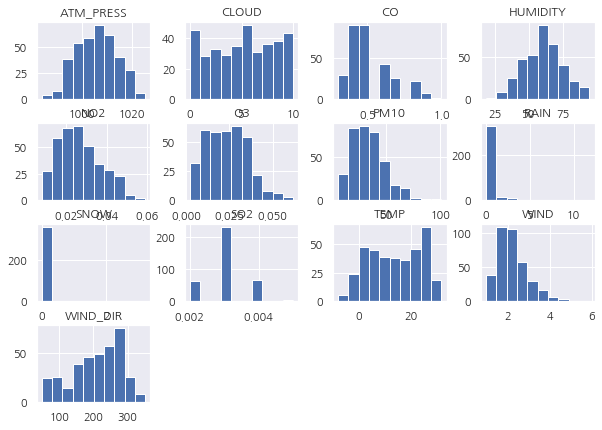

In [488]:
df_raw.hist(figsize=(10,7))

#### - 결측치 데이터를 그래프로 확인해본 결과 정규분포가 아니다.
- 평균이 아닌 최빈값으로 결측치 대체함

In [489]:
df_raw['CO'].value_counts()

0.4    90
0.5    90
0.6    43
0.3    30
0.7    26
0.8    22
0.9     8
1.0     2
Name: CO, dtype: int64

In [490]:
# 최빈값 대체 
df_raw['CO'].replace(to_replace = np.nan, value=0.4, inplace = True)

In [491]:
# 결측치 재확인 -> 모든 결측치 처리 완료
df_raw.isnull().sum()

MeasDate     0
PM10         1
O3           1
NO2          1
CO           0
SO2          1
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64

In [492]:
# 단, 'PM10', 'O3', 'NO2', 'CO', 'SO2' 데이터가 없어 정보가 부족하다고 판단되는 2020.5.24에 해당하는 데이터 한 행은 제거함
#df_raw=df_raw.dropna()
df_raw.drop(df_raw.index[328], inplace =True)

In [493]:
# 인덱스번호를 0 ~ 364번까지 초기화.
df_raw.index = list(range(365))

-  'PM10', 'O3', 'NO2', 'CO', 'SO2' 데이터가 없어 정보가 부족하다고 판단되는 2020.5.24에 해당하는 데이터 한 행은 제거함

In [494]:
df_raw.isnull().sum()

MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64

- 결측치를 모두 처리했다.

### 1. 데이터 구성하기 - 파생변수 생성

- 8방위로 나누어 날짜 데이터를 계절과 평일, 주말로 나눴다.

In [495]:
def separateDays(day):
    if day in [0,1,2,3,4]:
        return "주중"
    else:
        return "주말"
    
df_raw['Weekday']=df_raw['MeasDate'].dt.weekday
df_raw['Weekday']=df_raw['Weekday'].apply(separateDays)

In [496]:
def season(day):
    if day in [12, 1, 2]:
        return '겨울'
    elif day in [3,4,5]:
        return '봄'
    elif day in [6,7,8]:
        return '여름'
    elif day in [9,10,11]:
        return '가을'
    
df_raw['Month']=df_raw['MeasDate'].dt.month
df_raw['Month']=df_raw['Month'].apply(season)

In [497]:
def changeDir(dir):
    res = ''
    if dir <= 22:           res = "북"
    elif dir <= 67:         res = "북동"
    elif dir <= 112:        res = "동"
    elif dir <= 157:        res = "남동"
    elif dir <= 202:        res = "남"
    elif dir <= 247:        res = "남서"
    elif dir <= 292:        res = "서"
    elif dir <= 337:        res = "북서"
    else:                   res = "북"
    return res

In [498]:
df_raw['WIND_DIRECTION_NAME'] = df_raw['WIND_DIR'].apply(changeDir)

-요약 통계량으로 확인

In [499]:
df_raw.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,33.421918,0.023600,0.026814,0.499726,0.003033,13.853890,0.378712,2.223589,209.320548,60.232055,1005.866575,0.023014,5.055397
std,15.937983,0.011896,0.010271,0.147040,0.000632,9.841944,1.122268,0.723421,70.788136,14.504766,8.130936,0.222663,2.985655
min,5.000000,0.002000,0.008000,0.300000,0.002000,-7.950000,0.000000,0.940000,50.000000,17.900000,983.800000,0.000000,0.000000
25%,22.000000,0.014000,0.019000,0.400000,0.003000,5.480000,0.000000,1.720000,160.000000,49.600000,999.400000,0.000000,2.500000
50%,31.000000,0.023000,0.025000,0.500000,0.003000,13.870000,0.000000,2.090000,221.000000,61.000000,1006.500000,0.000000,5.290000
75%,42.000000,0.032000,0.034000,0.600000,0.003000,23.100000,0.100000,2.620000,266.000000,69.800000,1011.600000,0.000000,7.540000
max,101.000000,0.062000,0.059000,1.000000,0.005000,31.720000,11.800000,5.880000,351.000000,95.000000,1025.500000,3.200000,10.000000


--------------------------------------------------

## 2. 그래프 탐색

#### -목표변수와 설명변수와의 관계 살펴보기

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


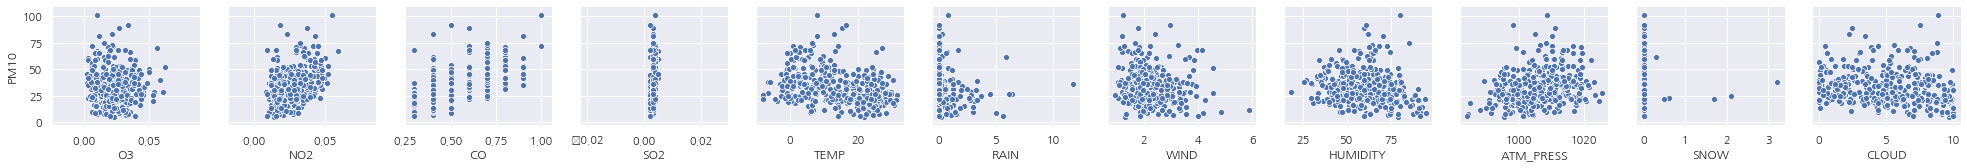

In [500]:
sns.pairplot(df_raw,y_vars=['PM10'], x_vars = ['O3', 'NO2', 'CO', 'SO2','TEMP','RAIN','WIND','HUMIDITY', 'ATM_PRESS','SNOW','CLOUD'])

- O3, TEMP, WIND, HUMIDITY가 미세먼지와 상관성이 약간 있는것으로 보여진다.

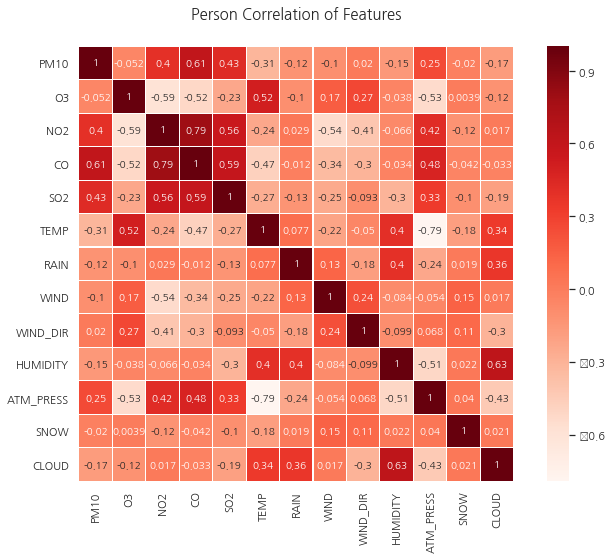

In [501]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(12, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(df_raw.corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = 'Reds', linecolor = "white", annot = True)

- 히트맵 결과 NO2가 0.4, CO가 0.61, SO2가 0.43으로 미세먼지와의 상관성이 비교적 높게 나왔다.
- ATM_PRESS는 0.25는 히트맵에서 나온 값이나 다른 변수와 비교해 봤을 때 상관성이 높다고 볼 수 없다.

- But! 한계점) 산점도와 히트맵은 선형적인 관계를 전제한다.
- 온도나 계절 같은 데이터들은 미세먼지와 실제로 비선형적인 관계를 가지고 있다.
- 이를 고려해서 t-test와 ANOVA 등 통계적인 가설 검정 진행

--------------------------------------------------

## 3. 통계적 가설 검정 및 인자 설정

#### -필요변수로 생성한 weekday, 풍향의 분산분석

In [502]:
df_dummy = pd.get_dummies(df_raw)
df_dummy.head(300)

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,...,Month_봄,Month_여름,WIND_DIRECTION_NAME_남,WIND_DIRECTION_NAME_남동,WIND_DIRECTION_NAME_남서,WIND_DIRECTION_NAME_동,WIND_DIRECTION_NAME_북,WIND_DIRECTION_NAME_북동,WIND_DIRECTION_NAME_북서,WIND_DIRECTION_NAME_서
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,...,0,1,0,0,0,0,0,0,0,1
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,...,0,1,0,0,0,0,0,0,0,1
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,...,0,1,0,0,0,0,0,0,0,1
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,...,0,1,0,0,0,0,0,0,0,1
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2020-04-21,28.0,0.030,0.012,0.3,0.002,7.59,0.0,4.56,284,...,1,0,0,0,0,0,0,0,0,1
296,2020-04-22,68.0,0.026,0.009,0.3,0.002,6.04,0.0,4.13,300,...,1,0,0,0,0,0,0,0,1,0
297,2020-04-23,37.0,0.027,0.012,0.3,0.002,7.70,0.0,3.60,288,...,1,0,0,0,0,0,0,0,0,1
298,2020-04-24,34.0,0.030,0.020,0.4,0.003,9.56,0.0,3.91,241,...,1,0,0,0,1,0,0,0,0,0


- 평일과 주말 사이에 유의미한 차이가 없다.
- 미세먼지와 상관관계가 없다.

### -2 Sample T-Test

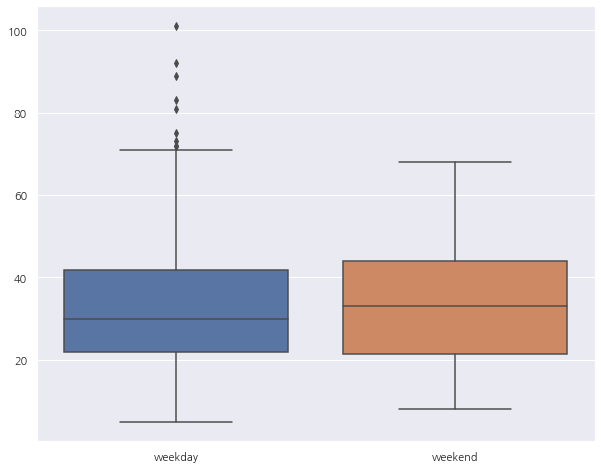

In [503]:
Weekend = list() # 주말
Weekday = list() # 주중

for x in range(len(df_dummy)):
    if df_dummy['Weekday_주말'][x] == 1:
        Weekend.append(df_dummy['PM10'][x])

    elif df_dummy['Weekday_주중'][x] == 1:
        Weekday.append(df_dummy['PM10'][x])


df1 = pd.DataFrame({'weekday' : Weekday }) # 주중
df2 = pd.DataFrame({'weekend' : Weekend }) # 주말

plt.figure(figsize=[10,8])
res=pd.concat([df1, df2], axis=1)

sns.boxplot(data=res)

In [504]:
# 정규성 검사
print(shapiro(df1))
print(shapiro(df2))
print()

# 등분산성 검사
print(stats.bartlett(df1['weekday'], df2['weekend']))
print()

t_result = stats.ttest_ind(df1,df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)
print('2-sample t-test')
print(t, p)
print('t:{}'.format(t))
print('p:{}'.format(p))

(0.9372698664665222, 4.042686185812272e-09)
(0.9632505178451538, 0.005849048960953951)

BartlettResult(statistic=2.0485566163498534, pvalue=0.15235056620776838)

2-sample t-test
[-0.317] [0.751]
t:[-0.317]
p:[0.751]


- 필요 변수로 생성한 풍향에 따라 평균값이 유의미하게 차이난다.
- '미세먼지 발생에 풍향이 영향을 줄 것이다.'는 가설 입증

### -ANOVA test

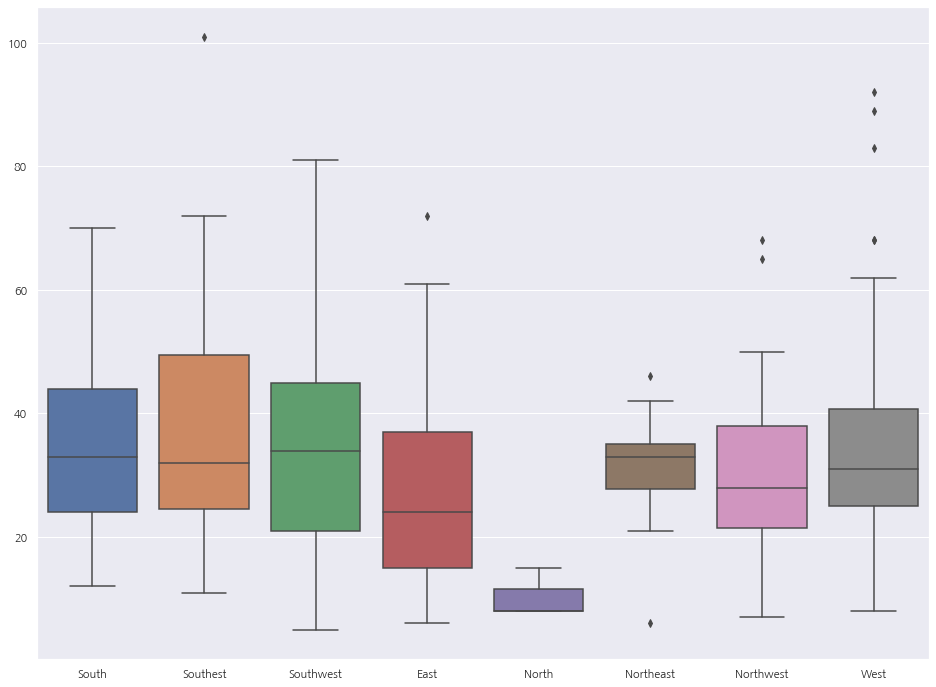

In [505]:
a = list()
b = list()
c = list()
d = list()
e = list()
f = list()
g = list()
h = list()


for x in range(len(df_dummy)):
    if df_dummy['WIND_DIRECTION_NAME_남'][x] == 1:
        a.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_남동'][x] == 1:
        b.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_남서'][x] == 1:
        c.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_동'][x] == 1:
        d.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_북'][x] == 1:
        e.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_북동'][x] == 1:
        f.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_북서'][x] == 1:
        g.append(df_dummy['PM10'][x])
    elif df_dummy['WIND_DIRECTION_NAME_서'][x] == 1:
        h.append(df_dummy['PM10'][x])
        
df_1 = pd.DataFrame({'South' : a }) 
df_2 = pd.DataFrame({'Southest' : b })
df_3 = pd.DataFrame({'Southwest' : c }) 
df_4 = pd.DataFrame({'East' : d })
df_5 = pd.DataFrame({'North' : e }) 
df_6 = pd.DataFrame({'Northeast' : f })
df_7 = pd.DataFrame({'Northwest' : g })
df_8 = pd.DataFrame({'West' : h })

plt.figure(figsize=[16,12])
res=pd.concat([df_1,df_2, df_3,df_4,df_5,df_6,df_7,df_8], axis=1)

sns.boxplot(data=res)

In [506]:
f_result = stats.f_oneway(df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8)
t, p = f_result.statistic.round(3), f_result.pvalue.round(3)
print(t, p)
print('one-way')
print('t:{}'.format(t))
print('p:{}'.format(p))

[2.487] [0.017]
one-way
t:[2.487]
p:[0.017]


- 필요 변수로 생성한 계절에 따라 평균값이 유의미하게 차이난다.
- 미세먼지 발생에 계절의 영향이 있을 것이다.

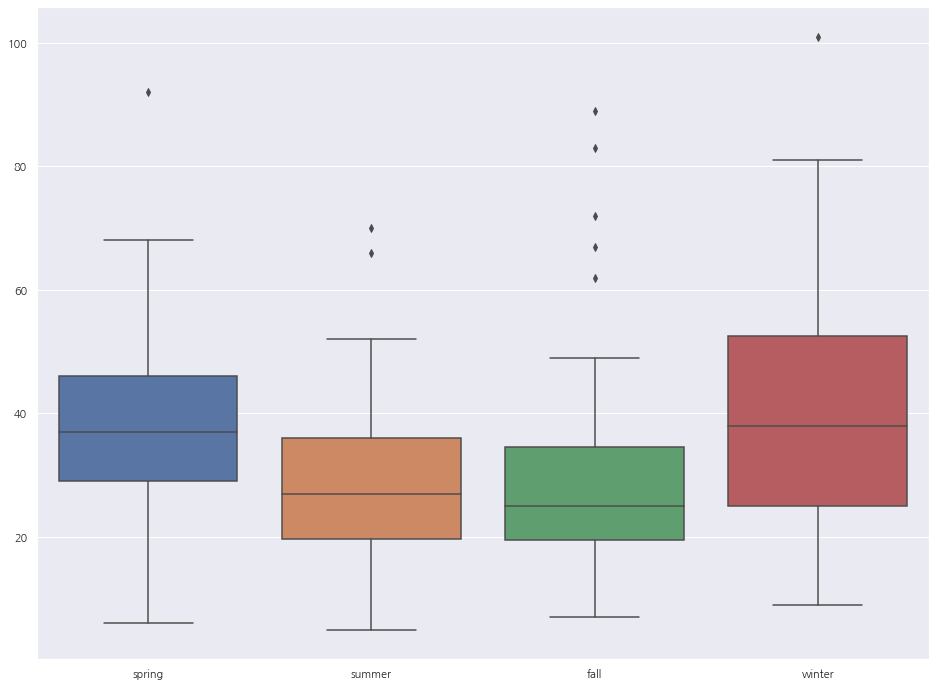

In [507]:
spring = list()
summer = list()
fall = list()
winter = list()

for x in range(len(df_dummy)):
    if df_dummy['Month_봄'][x] == 1:
        spring.append(df_dummy['PM10'][x])

    elif df_dummy['Month_여름'][x] == 1:
        summer.append(df_dummy['PM10'][x])
        
    elif df_dummy['Month_가을'][x] == 1:
        fall.append(df_dummy['PM10'][x])
        
    elif df_dummy['Month_겨울'][x] == 1:
        winter.append(df_dummy['PM10'][x])


df1 = pd.DataFrame({'spring' : spring }) # 봄
df2 = pd.DataFrame({'summer' : summer }) # 여름
df3 = pd.DataFrame({'fall' : fall }) # 가을
df4 = pd.DataFrame({'winter' : winter }) # 겨울

plt.figure(figsize=[16,12])
res=pd.concat([df1,df2, df3,df4], axis=1)

sns.boxplot(data=res)

In [508]:
a_result = stats.f_oneway(df1, df2, df3, df4)
t, p = a_result.statistic.round(3), a_result.pvalue.round(10)
print(t, p)
print('one-way')
print('t:{}'.format(t))
print('p:{}'.format(p))

[17.817] [1.e-10]
one-way
t:[17.817]
p:[1.e-10]


### -의사결정 나무

In [509]:
df_dummy.drop(['MeasDate'], axis=1, inplace=True)

In [510]:
df_dummy.head(200)

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,...,Month_봄,Month_여름,WIND_DIRECTION_NAME_남,WIND_DIRECTION_NAME_남동,WIND_DIRECTION_NAME_남서,WIND_DIRECTION_NAME_동,WIND_DIRECTION_NAME_북,WIND_DIRECTION_NAME_북동,WIND_DIRECTION_NAME_북서,WIND_DIRECTION_NAME_서
0,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,...,0,1,0,0,0,0,0,0,0,1
1,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,...,0,1,0,0,0,0,0,0,0,1
2,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,...,0,1,0,0,0,0,0,0,0,1
3,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,...,0,1,0,0,0,0,0,0,0,1
4,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,46.0,0.025,0.018,0.6,0.004,-0.95,0.0,2.45,295,61.1,...,0,0,0,0,0,0,0,0,1,0
196,25.0,0.020,0.019,0.4,0.003,-2.65,0.0,2.36,308,52.8,...,0,0,0,0,0,0,0,0,1,0
197,30.0,0.013,0.031,0.6,0.003,-2.37,0.0,1.58,234,44.4,...,0,0,0,0,1,0,0,0,0,0
198,36.0,0.015,0.027,0.6,0.004,-2.71,0.0,1.89,266,44.6,...,0,0,0,0,0,0,0,0,0,1


In [511]:
df_dust_y = df_dummy['PM10']
df_dust_x = df_dummy.drop('PM10', axis = 1, inplace=False)

In [512]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_dust_x,df_dust_y,test_size=0.3)
print('train data X size:',df_train_x.shape)
print('train data Y size:',df_train_y.shape)
print('test data X size:',df_test_x.shape)
print('test data Y size:',df_test_y.shape)

train data X size: (255, 26)
train data Y size: (255,)
test data X size: (110, 26)
test data Y size: (110,)


In [513]:
tree_uncustomized = DTR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  1.0
test data 설명력:  -0.13506504915043727


In [514]:

v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.442
0,O3,0.127
4,TEMP,0.056
16,Month_봄,0.054
8,HUMIDITY,0.051
5,RAIN,0.036
6,WIND,0.036
9,ATM_PRESS,0.033
1,NO2,0.032
11,CLOUD,0.024


Text(0, 0.5, '변수')

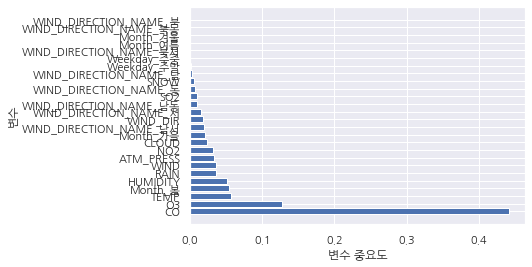

In [515]:
df_importance.sort_values('Importance', ascending=False, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

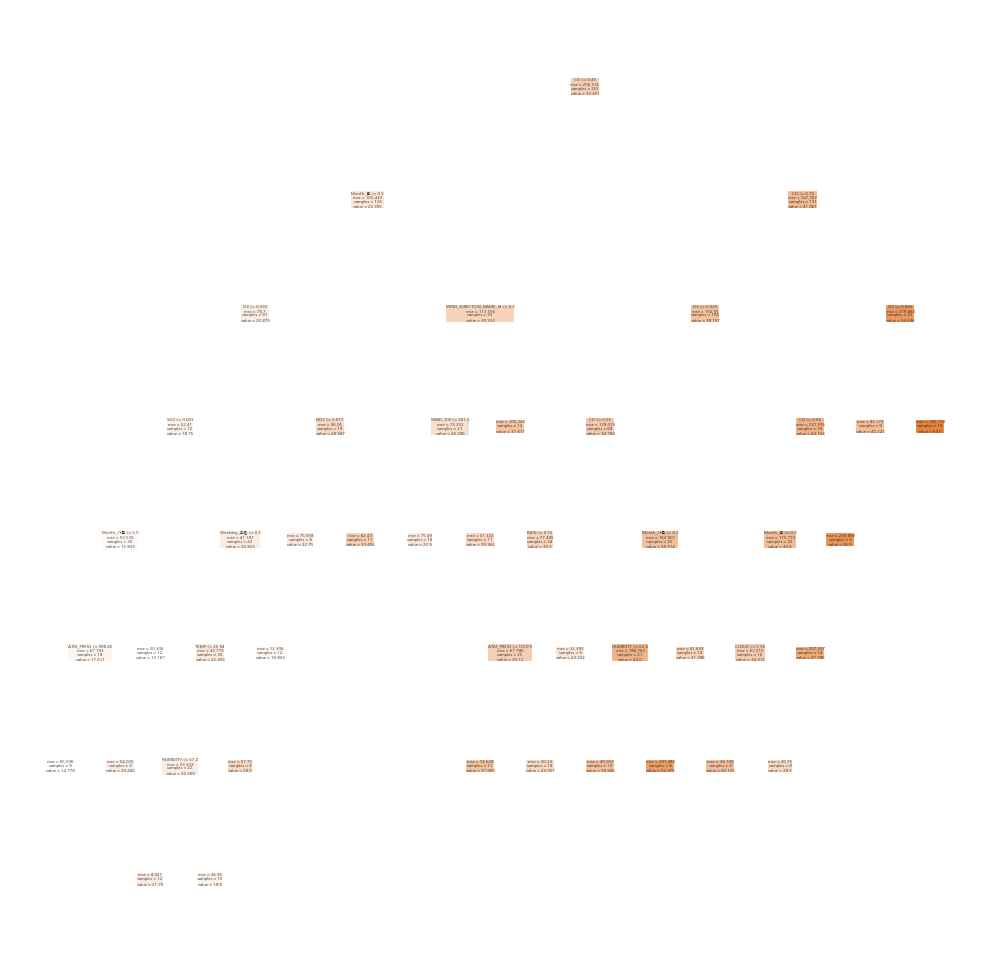

In [516]:
tree_graph = DTR( min_samples_leaf=8)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

### -랜덤 포레스트

In [517]:
tree_uncustomized = RFR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  0.9303179188594204
test data 설명력:  0.40570350058742605


In [518]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.423
0,O3,0.087
6,WIND,0.069
8,HUMIDITY,0.053
7,WIND_DIR,0.049
4,TEMP,0.045
11,CLOUD,0.045
1,NO2,0.044
16,Month_봄,0.039
9,ATM_PRESS,0.038


Text(0, 0.5, '변수')

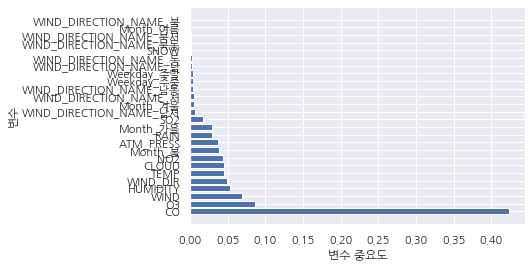

In [519]:
df_importance.sort_values('Importance', ascending=False, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### -그래디언트 부스팅

In [520]:
tree_uncustomized = GBR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  0.9396393097439076
test data 설명력:  0.39389183966758684


In [521]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.453
0,O3,0.124
16,Month_봄,0.057
11,CLOUD,0.052
1,NO2,0.044
7,WIND_DIR,0.042
4,TEMP,0.041
6,WIND,0.037
14,Month_가을,0.036
9,ATM_PRESS,0.033


Text(0, 0.5, '변수')

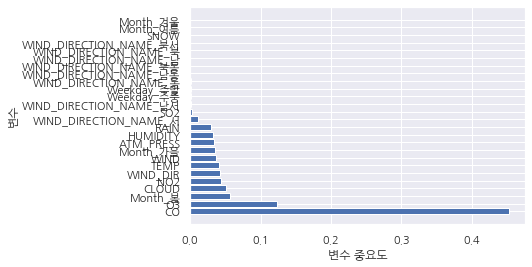

In [522]:
df_importance.sort_values('Importance', ascending=False, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### ∴의사결정 나무와 앙상블 기법 결과 'O3, 'NO2', 'CO','TEMP', 'HUMIDITY', 'CLOUD', 'SEASON', 'WIND_DIRECTION_NAME'를 주요 인자로 선정함.

--------------------------------------------------

## 4. 모델링

### -다중회귀분석

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


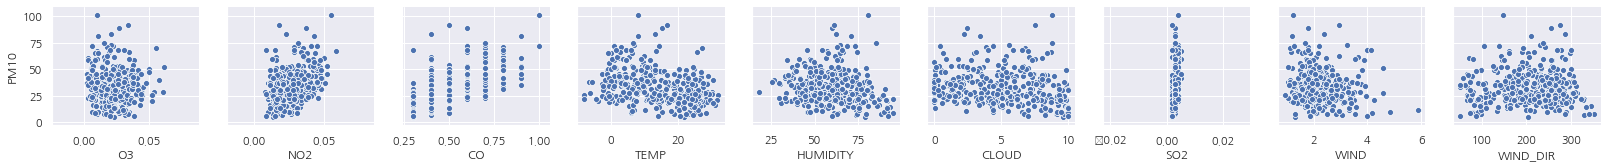

In [523]:
sns.pairplot(df_raw, y_vars='PM10', x_vars=['O3','NO2','CO','TEMP','HUMIDITY','CLOUD', 'SO2','WIND', 'WIND_DIR'])

- NO2, WIND, TEMP, HUMIDITY에서 약한 선형관계 확인

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


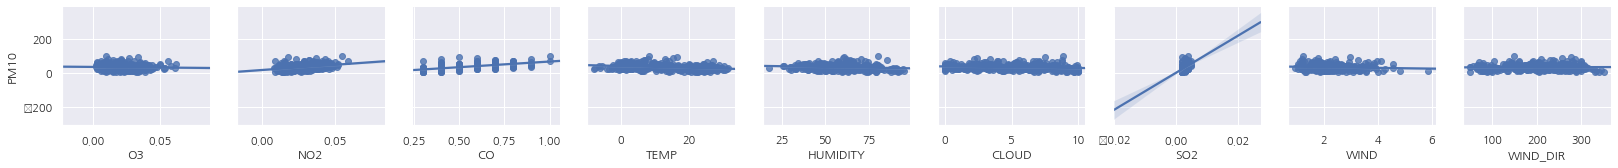

In [524]:
sns.pairplot(df_raw, y_vars='PM10', x_vars=['O3','NO2','CO','TEMP','HUMIDITY','CLOUD', 'SO2','WIND','WIND_DIR'],kind='reg')

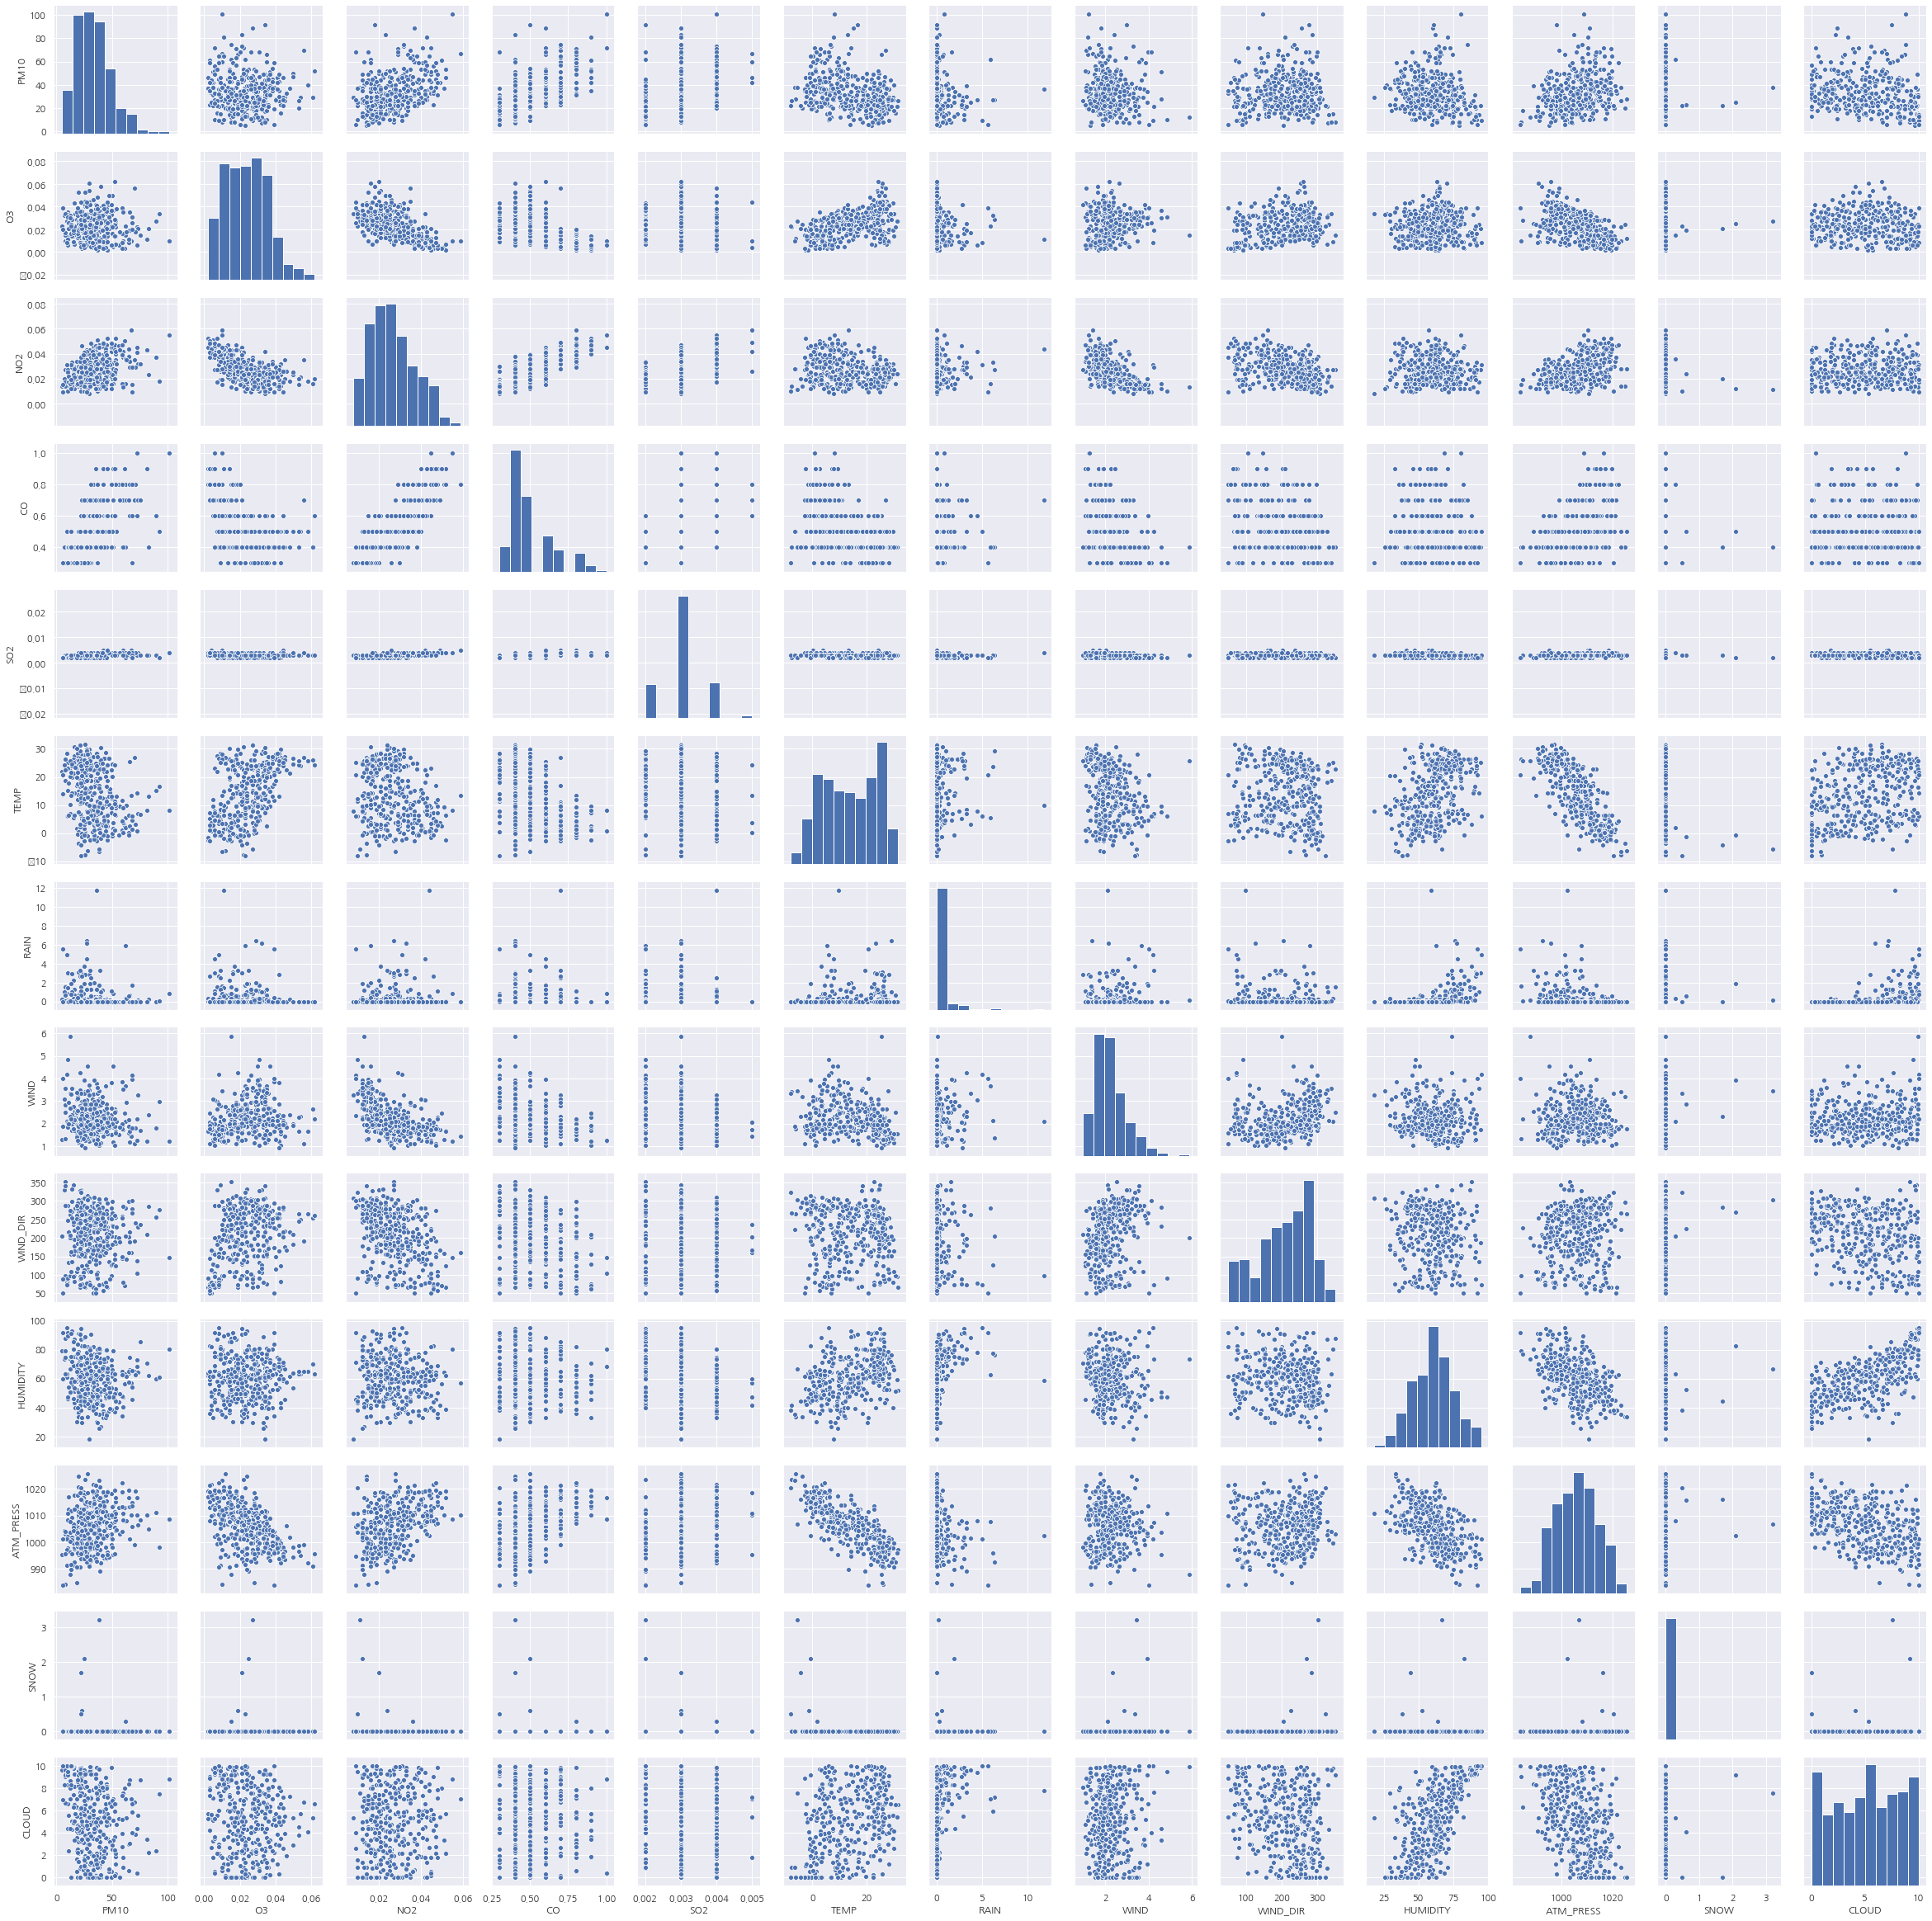

In [525]:
sns.pairplot(df_raw)

In [526]:
df_raw.corr().round(3)

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
PM10,1.000,-0.052,0.396,0.613,0.429,-0.310,-0.121,-0.100,0.020,-0.150,0.253,-0.020,-0.172
O3,-0.052,1.000,-0.592,-0.519,-0.234,0.516,-0.104,0.165,0.269,-0.038,-0.534,0.004,-0.119
NO2,0.396,-0.592,1.000,0.791,0.563,-0.237,0.029,-0.537,-0.408,-0.066,0.420,-0.121,0.017
CO,0.613,-0.519,0.791,1.000,0.594,-0.473,-0.012,-0.339,-0.302,-0.034,0.476,-0.042,-0.033
SO2,0.429,-0.234,0.563,0.594,1.000,-0.274,-0.129,-0.253,-0.093,-0.302,0.334,-0.103,-0.191
TEMP,-0.310,0.516,-0.237,-0.473,-0.274,1.000,0.077,-0.216,-0.050,0.404,-0.792,-0.185,0.342
RAIN,-0.121,-0.104,0.029,-0.012,-0.129,0.077,1.000,0.126,-0.183,0.397,-0.236,0.019,0.358
WIND,-0.100,0.165,-0.537,-0.339,-0.253,-0.216,0.126,1.000,0.235,-0.084,-0.054,0.146,0.017
WIND_DIR,0.020,0.269,-0.408,-0.302,-0.093,-0.050,-0.183,0.235,1.000,-0.099,0.068,0.108,-0.297
HUMIDITY,-0.150,-0.038,-0.066,-0.034,-0.302,0.404,0.397,-0.084,-0.099,1.000,-0.510,0.022,0.628


- 다중선형회귀 결과 O3,CO,WIND,WIND_DIR이 미세먼지 농도와 선형적인 관계를 가지고 있다는 것을 알게 되었다

In [527]:
reg_model = smf.ols(formula = '''PM10~ O3 + NO2 + CO + TEMP + HUMIDITY + CLOUD + SO2 + WIND + WIND_DIR''',data = df_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     43.10
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           8.25e-52
Time:                        19:16:27   Log-Likelihood:                -1393.2
No. Observations:                 365   AIC:                             2806.
Df Residuals:                     355   BIC:                             2845.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.1528      7.058     -4.839      0.0

In [528]:
# 다중 공선성을 위한 변수제거
mul_re = df_raw.copy()
mul_re.drop(['MeasDate', 'PM10', 'WIND_DIRECTION_NAME', 'Month', 'Weekday'], axis=1, inplace=True)

In [529]:
# 모든 변수들의 다중 공선성(VIF)이 10미만이므로 재확인할 필요가 없다고 판단.

# 상수항 추가
df_x_const = add_constant(mul_re)

df_x_vif = pd.DataFrame()
df_x_vif['variable'] = df_x_const.columns
df_x_vif['VIF'] = [variance_inflation_factor(df_x_const.values, i)for i in range(df_x_const.shape[1])]

df_x_vif.sort_values("VIF", inplace = True)
df_x_vif.round(3)

,variable,VIF
11,SNOW,1.116
6,RAIN,1.370
8,WIND_DIR,1.510
7,WIND,1.925
4,SO2,1.967
12,CLOUD,2.087
9,HUMIDITY,2.707
1,O3,2.820
10,ATM_PRESS,4.646
3,CO,4.753


## 결론도출

In [530]:
scaler = StandardScaler()
cols = df_x_const.columns

np_scaled = scaler.fit_transform(df_x_const)
df_scaled = pd.DataFrame(np_scaled, columns = cols)

df_scaled["PM10"] = df_raw['PM10']
reg_model_scaled = smf.ols(formula = "PM10~O3+ CO + WIND + WIND_DIR + SO2 + CLOUD + HUMIDITY + TEMP + NO2", data = df_scaled)
reg_result_scaled = reg_model_scaled.fit()
print(reg_result_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     43.10
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           8.25e-52
Time:                        19:16:27   Log-Likelihood:                -1393.2
No. Observations:                 365   AIC:                             2806.
Df Residuals:                     355   BIC:                             2845.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.4219      0.584     57.236      0.0

- 미세먼지 발생에 CO가 가장 큰 영향을 미친다.
- O3와 WIND도 영향 인자이다.

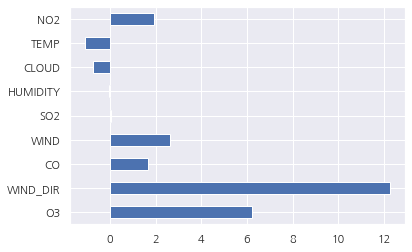

In [531]:
df_reg_coef = pd.DataFrame({"Coef":reg_result_scaled.params.values[1:]}, index = ['O3','WIND_DIR', 'CO', 'WIND','SO2','HUMIDITY','CLOUD','TEMP','NO2'])
df_reg_coef.plot.barh(y = 'Coef', legend = False)

## -의사결정나무

In [532]:
df_y = df_raw['PM10']
df_x = df_raw.drop(['O3','NO2','CO','TEMP','HUMIDITY','CLOUD', 'SO2','WIND', 'WIND_DIR', 'Month'], axis = 1, inplace = True)


- 의사결정 나무는 r제곱을 score의 default 값으로 가진다.
- 변수들 간의 관계가 선형적이지 않은 경우 설명력이 음수가 나오기도 한다.

In [533]:
tree_uncustomized = DTR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  1.0
test data 설명력:  -0.12041831219096143


In [534]:
# 잎사귀 노드의 최소 자료수 변경에 따른 모델 성능

train_score = [];test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DTR( min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

df_score_leaf = pd.DataFrame()

df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf["TestScore"] = test_score

In [535]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,-0.051
1,2,0.939,-0.009
2,3,0.867,0.013
3,4,0.827,0.078
4,5,0.753,0.128
5,6,0.733,0.153
6,7,0.717,0.136
7,8,0.692,0.168
8,9,0.676,0.191
9,10,0.652,0.177


- 잎사귀 노드 최소 자료수를 2개로 선정

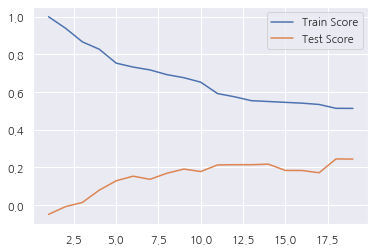

In [536]:
plt.plot(para_leaf, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = "-",label = 'Test Score')
plt.legend()

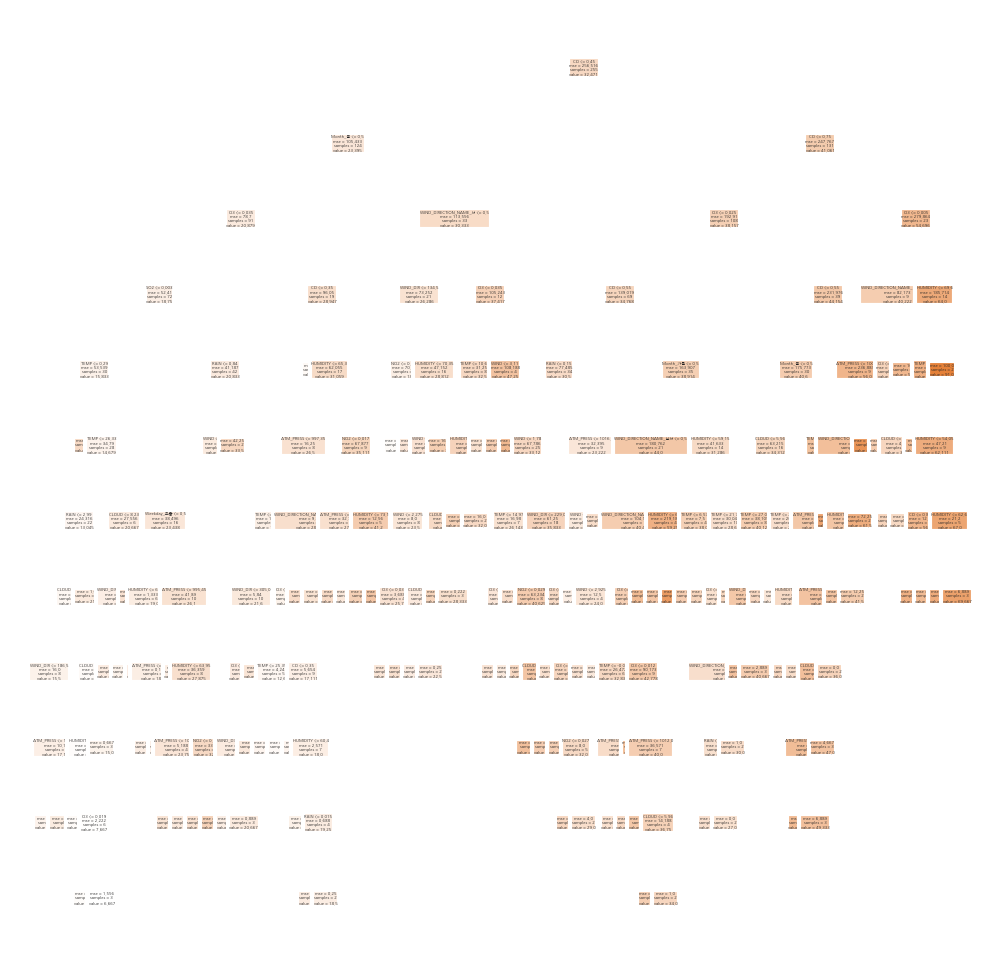

In [537]:
tree_graph = DTR(min_samples_leaf=2)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

In [538]:
# 분리 노드의 최소 자료수
train_score = [];test_score=[]
para_split = [n_leaf * 2 for n_leaf in range(1,20)]

for v_min_samples_split in para_split:
    tree = DTR(min_samples_leaf=2, min_samples_split = v_min_samples_split)

    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.939,0.041
1,4,0.939,0.005
2,6,0.904,0.008
3,8,0.888,0.029
4,10,0.826,0.005
5,12,0.816,0.008
6,14,0.794,0.001
7,16,0.741,0.080
8,18,0.715,0.184
9,20,0.699,0.198


- train과 test의 정확도를 고려한 결과 분리노드의 최소 자료수는 14개로 선정

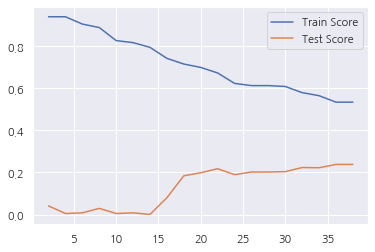

In [539]:
plt.plot(para_split, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_split, test_score, linestyle = "-",label = 'Test Score')
plt.legend()

In [540]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DTR(max_depth = v_max_depth,min_samples_leaf = 2, min_samples_split = 23)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.304,0.061
1,2,0.416,0.214
2,3,0.536,0.198
3,4,0.586,0.278
4,5,0.651,0.216
5,6,0.667,0.212
6,7,0.670,0.191
7,8,0.670,0.191
8,9,0.670,0.191
9,10,0.670,0.191


- 깊이를 6으로 선정

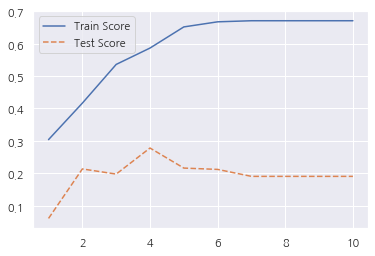

In [541]:
plt.plot(para_depth, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

## 최종 의사결정 나무 선정

In [542]:
dt_final = DTR(min_samples_leaf=2, min_samples_split=24, max_depth = 6)
dt_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=24,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

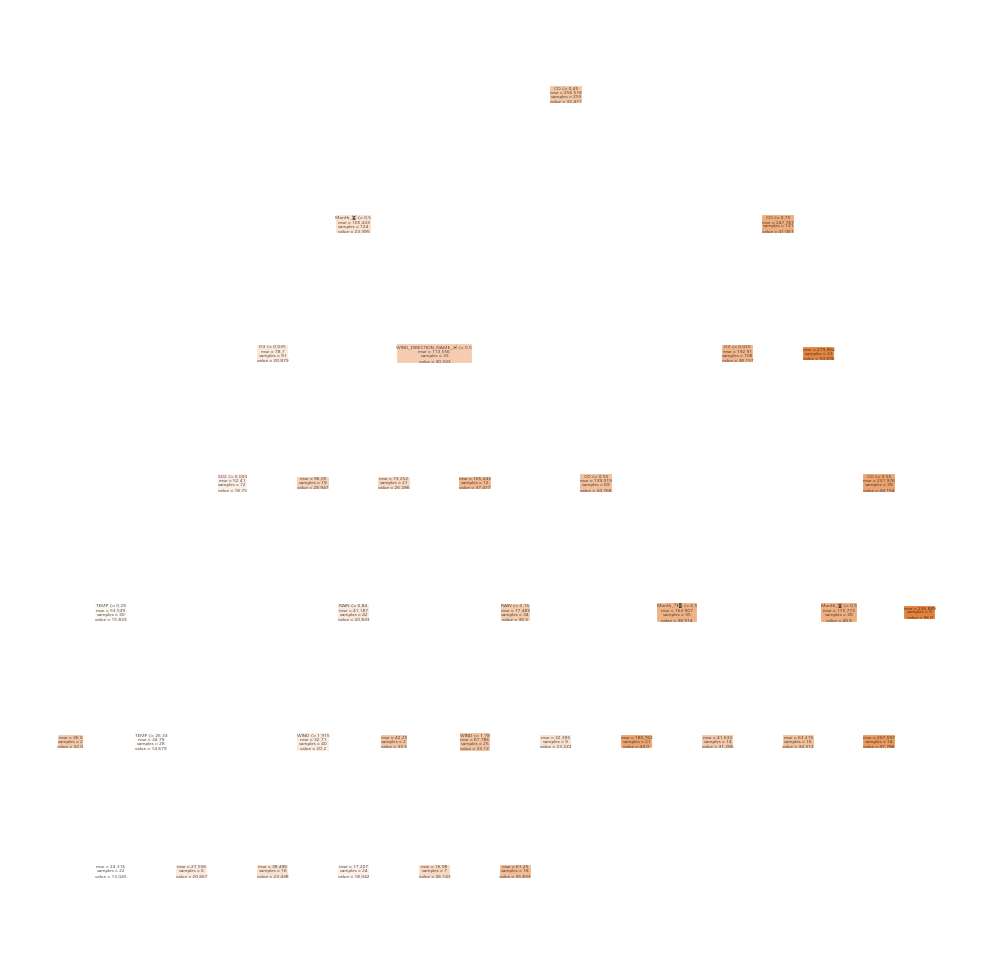

In [543]:
tree_graph = DTR(min_samples_leaf=2, min_samples_split=24, max_depth = 6)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()

In [544]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = dt_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.689
0,O3,0.093
16,Month_봄,0.087
14,Month_가을,0.034
5,RAIN,0.024
25,WIND_DIRECTION_NAME_서,0.023
4,TEMP,0.021
6,WIND,0.019
3,SO2,0.011
9,ATM_PRESS,0.000


Text(0, 0.5, '변수')

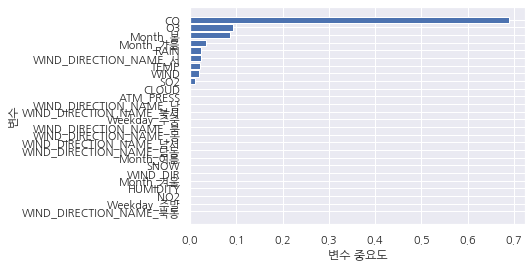

In [545]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- 파라미터 값을 지정하기 전의 설명력은 음수였다.
- 그러나 파라미터 값을 수정하고 나니 설명력이 32%로 증가했다.

In [546]:
print('train data 설명력: ', dt_final.score(df_train_x,df_train_y))
print('test data 설명력: ', dt_final.score(df_test_x,df_test_y))

train data 설명력:  0.6194819516578627
test data 설명력:  0.2108417252215017


## -랜덤 포레스트

In [547]:
tree_uncustomized = RFR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  0.9320491488278735
test data 설명력:  0.412020193129418


In [548]:
# 잎사귀 노드의 최소 자료수 변경에 따른 모델 성능

train_score = [];test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    rf = RFR( min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

df_score_leaf = pd.DataFrame()

df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf["TestScore"] = test_score

In [549]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.928,0.422
1,2,0.894,0.411
2,3,0.853,0.410
3,4,0.810,0.397
4,5,0.779,0.397
5,6,0.748,0.380
6,7,0.725,0.379
7,8,0.695,0.383
8,9,0.684,0.391
9,10,0.659,0.369


- 잎사귀 노드의 최소 자료수 : 4개로 선정

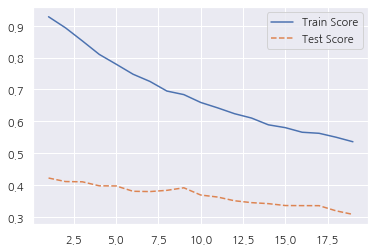

In [550]:
plt.plot(para_leaf, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

In [551]:
# 분리 노드의 최소 자료수
train_score = [];test_score=[]
para_split = [n_leaf * 2 for n_leaf in range(1,20)]

for v_min_samples_split in para_split:
    tree = RFR(min_samples_leaf=4, min_samples_split = v_min_samples_split)

    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.809,0.406
1,4,0.806,0.396
2,6,0.809,0.406
3,8,0.813,0.406
4,10,0.784,0.401
5,12,0.773,0.402
6,14,0.753,0.401
7,16,0.733,0.401
8,18,0.722,0.385
9,20,0.697,0.394


- 분리 노드의 최소 자료수 : 7개로 선정

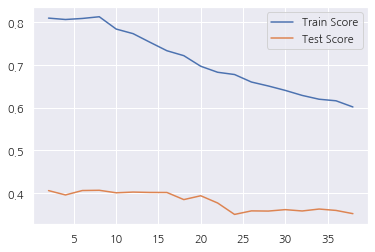

In [552]:
plt.plot(para_split, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_split, test_score, linestyle = "-",label = 'Test Score')
plt.legend()

In [553]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=RFR(max_depth = v_max_depth,min_samples_leaf = 4, min_samples_split = 7)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.359,0.179
1,2,0.485,0.267
2,3,0.620,0.345
3,4,0.709,0.387
4,5,0.753,0.388
5,6,0.789,0.401
6,7,0.807,0.408
7,8,0.809,0.391
8,9,0.808,0.417
9,10,0.814,0.420


- 깊이 : 6으로 선정

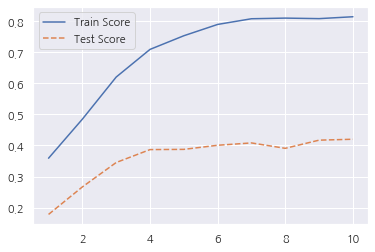

In [554]:
plt.plot(para_depth, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

## -최종 랜덤 포레스트 생성

In [555]:
rf_final = RFR(min_samples_leaf=4, min_samples_split=7, max_depth = 6)
rf_final.fit(df_train_x,df_train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [556]:
df_importance= pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.503
0,O3,0.100
6,WIND,0.056
16,Month_봄,0.055
8,HUMIDITY,0.048
7,WIND_DIR,0.038
11,CLOUD,0.034
1,NO2,0.032
4,TEMP,0.031
14,Month_가을,0.028


Text(0, 0.5, '변수')

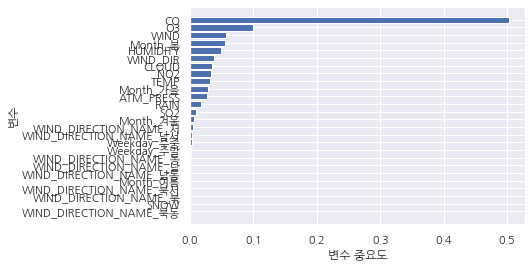

In [557]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [558]:
print('train data 설명력: ', rf_final.score(df_train_x,df_train_y))
print('test data 설명력: ', rf_final.score(df_test_x,df_test_y))

train data 설명력:  0.7898194354141307
test data 설명력:  0.406257102052588


## -그래디언트 부스팅

In [559]:
tree_uncustomized = GBR()
tree_uncustomized.fit(df_train_x, df_train_y)

print('train data 설명력: ', tree_uncustomized.score(df_train_x,df_train_y))
print('test data 설명력: ', tree_uncustomized.score(df_test_x,df_test_y))

train data 설명력:  0.9396393097439076
test data 설명력:  0.39468931533470614


In [560]:
# 잎사귀 노드의 최소 자료수 변경에 따른 모델 성능

train_score = [];test_score=[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    rf = GBR( min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

df_score_leaf = pd.DataFrame()

df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf["TestScore"] = test_score

In [561]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.940,0.395
1,2,0.935,0.430
2,3,0.934,0.429
3,4,0.927,0.411
4,5,0.923,0.438
5,6,0.912,0.431
6,7,0.913,0.402
7,8,0.906,0.402
8,9,0.905,0.399
9,10,0.900,0.390


- 잎사귀 노드 최소 자료수 : 4개로 선정

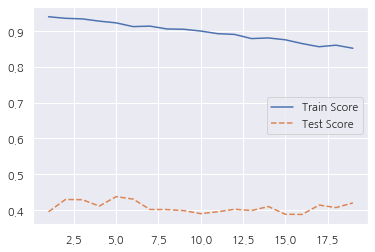

In [563]:
plt.plot(para_leaf, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

In [ ]:
tree_graph = GBR(min_samples_leaf=4)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()
tree_graph = GBR(min_samples_leaf=4)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True)
plt.show()
# 분리 노드의 최소 자료수
train_score = [];test_score=[]
para_split = [n_leaf * 2 for n_leaf in range(1,20)]
​
for v_min_samples_split in para_split:
    tree = GBR(min_samples_leaf=4, min_samples_split = v_min_samples_split)
​
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

- 분리 노드의 최소 자료수 : 13개 선정

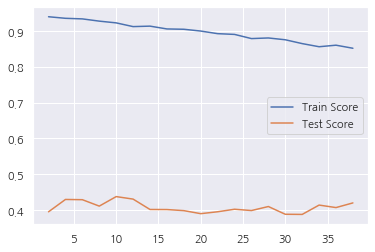

In [565]:
plt.plot(para_split, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_split, test_score, linestyle = "-",label = 'Test Score')
plt.legend()

In [566]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=GBR(max_depth = v_max_depth,min_samples_leaf = 4, min_samples_split = 7)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.623,0.378
1,2,0.825,0.425
2,3,0.927,0.417
3,4,0.977,0.397
4,5,0.994,0.367
5,6,0.998,0.370
6,7,0.998,0.354
7,8,0.999,0.335
8,9,0.999,0.323
9,10,0.999,0.364


- 깊이 : 3으로 선정

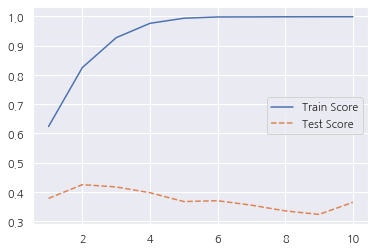

In [567]:
plt.plot(para_depth, train_score, linestyle = "-",label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = "--",label = 'Test Score')
plt.legend()

In [568]:
gb_final = GBR(min_samples_leaf=4, min_samples_split=13, max_depth = 3)
gb_final.fit(df_train_x,df_train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=13,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [579]:
df_importance= pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.458
0,O3,0.123
16,Month_봄,0.058
11,CLOUD,0.054
4,TEMP,0.050
7,WIND_DIR,0.044
6,WIND,0.043
8,HUMIDITY,0.041
14,Month_가을,0.039
1,NO2,0.036


Text(0, 0.5, '변수')

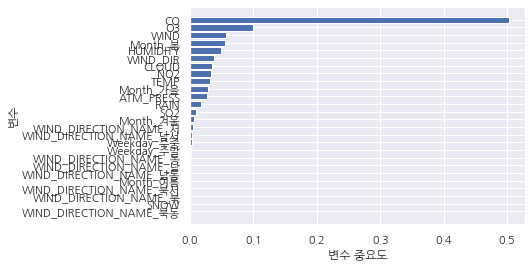

In [578]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [570]:
print('train data 설명력: ', gb_final.score(df_train_x,df_train_y))
print('test data 설명력: ', gb_final.score(df_test_x,df_test_y))

train data 설명력:  0.9182747349927576
test data 설명력:  0.43299953152156123


## 모델 평가

In [571]:
# 평가 함수 정의

def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true -y_pred)/y_true))*100

In [572]:
models = ['회귀분석', '의사결정나무', '랜덤 포레스트', '그래디언트 부스팅']
mse, rmse, mae, mape = [], [], [], []

In [573]:
#회귀분석 예측
lr_y_pred = reg_result_scaled.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,lr_y_pred))
rmse.append(root_mean_squared_error(df_test_y,lr_y_pred))
mae.append(mean_absolute_error(df_test_y,lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,lr_y_pred))

In [574]:
# 의사결정 나무 예측
dt_y_pred = dt_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y,dt_y_pred))
mae.append(mean_absolute_error(df_test_y,dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,dt_y_pred))

In [575]:
# 랜덤 포레스트 예측
rf_y_pred = rf_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y,rf_y_pred))
mae.append(mean_absolute_error(df_test_y,rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,rf_y_pred))

In [576]:
# 그래디언트 부스팅 예측
gb_y_pred = gb_final.predict(df_test_x)

mse.append(mean_squared_error(df_test_y,gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y,gb_y_pred))
mae.append(mean_absolute_error(df_test_y,gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y,gb_y_pred))

['회귀분석', '의사결정나무', '랜덤 포레스트', '그래디언트 부스팅'] [273567.81748488394, 188.57810919706768, 141.88144079910643, 135.4910411216648]


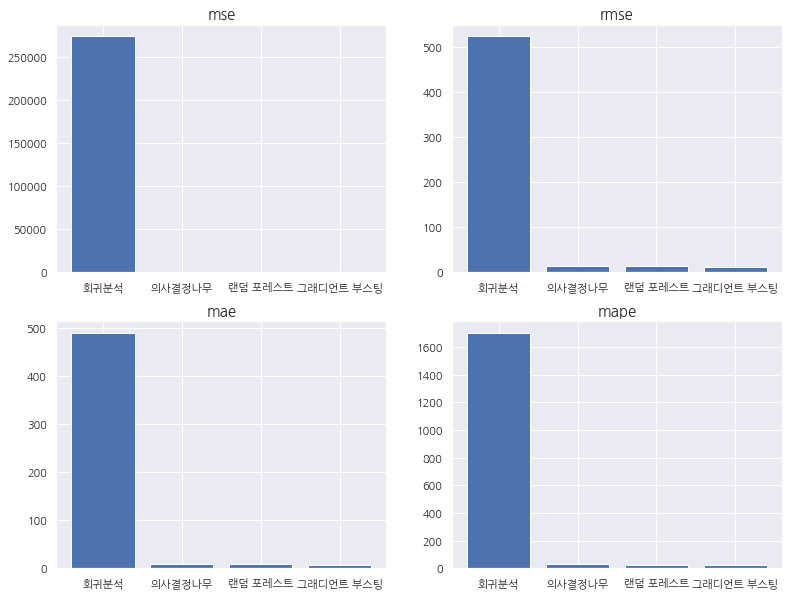

In [577]:
# 평가

fig, ax = plt.subplots(2,2, figsize = (13,10))
print(models, mse)

ax[0,0].bar(models, mse)
ax[0,0].set_title('mse').set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title('rmse').set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title('mae').set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title('mape').set_fontsize(15)
plt.show()